# Data Preprocessing

In [1]:
# reproduceability
import os
import numpy as np
import pandas as pd
import torch
import random


def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.cuda.manual_seed_all(seed) # if use multi-GPU

    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

def get_device() -> torch.device:
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = get_device()
set_seed(42)
print(device)

cpu


In [101]:
import pandas as pd
import numpy as np 
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler

columns_ = [i+1 for i in range(48)]
train = pd.read_excel('./dataset/Pembrolizumab_preprocessing_training_input1.xlsx', usecols= columns_)
label = train['Label']
train.drop('Label', axis=1, inplace=True)
print(f'train samples: {len(train)}, label samples: {len(label)}')
print(f'number of features: {len(train.columns)}')
count = label.value_counts()
print(count)
print(227/1110, (1110-227)/1110)
train.head()


train samples: 1337, label samples: 1337
number of features: 47
1    1110
0     227
Name: Label, dtype: int64
0.2045045045045045 0.7954954954954955


,SOC,a,agg1,agg2,agg3,agg4,agg5,agg6,agg7,agg8,...,report_type2,report_type3,report_type4,report_type5,notifier1,notifier2,notifier3,notifier4,notifier5,notifier6
0,15,4539,1,0,2,6,221,1053,1029,615,...,1763,9,40,0,2618,122,543,2,1049,205
1,8,2663,1,1,3,2,117,562,503,364,...,1150,11,1,0,944,162,631,2,836,88
2,8,1738,1,0,0,0,70,430,400,292,...,682,6,1,0,590,50,404,1,654,39
3,7,1363,0,0,0,1,53,336,351,236,...,445,6,1,0,670,112,201,1,359,20
4,21,1266,0,0,0,0,19,231,546,363,...,437,0,1,0,1154,81,22,0,7,2


In [3]:
print(f'mean value\n')
print(f'{train.mean()}\n')
print(f'var value\n')
print(f'{train.var()}\n')

mean value

SOC                12.924458
a                  49.062079
agg1                0.008227
agg2                0.011967
agg3                0.020942
agg4                0.031414
agg5                2.153328
agg6               12.565445
agg7               12.336574
agg8                8.444278
agg9               13.489903
sex1               26.612565
sex2               19.788332
sex3                2.602094
serious            39.135378
seriousness1        8.192221
seriousness2        1.738968
seriousness3       11.917726
seriousness4        0.531788
seriousness5        0.010471
seriousness6       11.797307
outcome1            8.766642
outcome2            5.993269
outcome3            7.784592
outcome4            0.401645
outcome5            4.724757
outcome6           19.340314
outcome7            0.004488
outcome8            0.020942
score_causality     0.120396
region1             0.008975
region2            23.079282
region3             1.055348
region4            14.857891
re

In [4]:
# Standardization
scaler = StandardScaler()
scaler.fit(train)
train_stand = scaler.transform(train) # returns numpy
print(f'data type: {type(train_stand)}')
train_stand_ = pd.DataFrame(train_stand) # convert to dataframe
print(f'data type: {type(train_stand_)}')

print(f'mean value\n')
print(f'{train_stand_.mean()}\n')
print(f'var value\n')
print(f'{train_stand_.var()}\n')

data type: <class 'numpy.ndarray'>
data type: <class 'pandas.core.frame.DataFrame'>
mean value

0    -8.802067e-17
1     0.000000e+00
2    -2.657228e-17
3     0.000000e+00
4    -5.314456e-18
5     4.251565e-17
6     2.125782e-17
7    -4.251565e-17
8     0.000000e+00
9     2.125782e-17
10    2.125782e-17
11    2.125782e-17
12   -4.251565e-17
13    1.062891e-17
14    0.000000e+00
15   -2.125782e-17
16   -2.125782e-17
17    0.000000e+00
18    2.125782e-17
19    0.000000e+00
20   -2.125782e-17
21    4.251565e-17
22    0.000000e+00
23    2.125782e-17
24    0.000000e+00
25   -5.314456e-18
26   -2.125782e-17
27    1.860060e-17
28    2.657228e-17
29   -2.657228e-17
30    1.062891e-17
31    0.000000e+00
32    0.000000e+00
33   -2.125782e-17
34   -2.125782e-17
35   -2.125782e-17
36    2.125782e-17
37    0.000000e+00
38   -2.125782e-17
39    0.000000e+00
40    1.062891e-17
41    2.125782e-17
42    0.000000e+00
43   -2.125782e-17
44    0.000000e+00
45    0.000000e+00
46    3.188673e-17
dtype: floa

In [5]:
# Stratified K Folds, train, val set ratio = 0.8: 0.2
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1004)
k_folded_data = list(skf.split(train_stand_, label)) # returns 5 tuples with index of (train_index, test_index)
print(f'Stratified Samples: {len(k_folded_data)}')

def data_split(train, train_index, test_index, selected_features = []):
    selected_features = np.array(selected_features)
    if len(selected_features):
        train_x, val_x = train.iloc[train_index].iloc[:, selected_features], train.iloc[test_index].iloc[:, selected_features]
        train_y, val_y = label.iloc[train_index], label.iloc[test_index]
    else:
        train_x, val_x = train.iloc[train_index], train.iloc[test_index]
        train_y, val_y = label.iloc[train_index], label.iloc[test_index]
    return train_x.reset_index(drop=True), train_y.reset_index(drop=True), val_x.reset_index(drop=True), val_y.reset_index(drop=True)

# data_split test
train_index = k_folded_data[0][0]
test_index = k_folded_data[0][1]

train_x, train_y, val_x, val_y  = data_split(train_stand_, train_index, test_index)

print(f'Train samples: {len(train_x)} ({(round(len(train_x)/len(train_stand_),2)*100)}%)')
print(f'Valid samples: {len(val_x)} ({(round(len(val_x)/len(train_stand_),2)*100)}%)')
print(f'Number of features: {len(train_x.columns)}')
train_x.head()

Stratified Samples: 5
Train samples: 1069 (80.0%)
Valid samples: 268 (20.0%)
Number of features: 47


,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
0,0.364364,23.723930,10.979319,-0.110055,11.830669,24.603862,25.085226,22.985199,22.365163,20.294748,...,24.333257,8.061674,30.999036,-0.027359,26.011776,11.526744,16.566839,9.026692,20.716079,29.991524
1,-0.864495,13.811523,10.979319,9.086391,17.808600,8.114958,13.164261,12.138065,10.793904,11.896539,...,15.797513,9.907774,0.684281,-0.027359,9.222150,15.402011,19.295770,9.026692,16.462895,12.774532
2,-0.864495,8.924009,10.979319,-0.110055,-0.125192,-0.129494,7.776902,9.221932,8.528049,9.487491,...,9.280827,5.292523,0.684281,-0.027359,5.671656,4.551264,12.256369,4.432597,12.828718,5.563998
3,1.593223,6.017919,-0.091080,-0.110055,-0.125192,-0.129494,3.879663,5.819776,5.360252,5.873919,...,3.766708,7.138624,4.570788,-0.027359,5.109995,6.779543,6.333348,4.432597,6.578733,3.650998
4,1.417672,5.806567,-0.091080,-0.110055,-0.125192,-0.129494,3.306540,6.195338,5.690231,5.505870,...,3.766708,15.446076,13.121104,-0.027359,6.112960,7.457714,5.123936,-0.161498,4.102700,6.152613


# Feature Selection

In [6]:
# example
selected_columns=  [16,17,18,19,20]
train_x, train_y, val_x, val_y  = data_split(train_stand_, train_index, test_index, selected_columns)
print(f'Number of features: {len(train_x.columns)}')
train_x.head()

Number of features: 5


,16,17,18,19,20
0,15.410105,8.706232,7.523187,9.087259,32.099452
1,0.997687,-0.314657,-0.276519,-0.096161,-0.149317
2,5.548977,10.204910,15.322893,9.087259,6.775682
3,3.273332,5.132461,1.803403,9.087259,4.552214
4,11.048452,9.916702,2.323383,-0.096161,3.839347


# Modelling

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim

# Customized the dataset
class PharDataset(Dataset): 
  def __init__(self, x_data, y):
    self.x_data = x_data
    self.y = y

  def __len__(self): 
    return len(self.x_data)

  def __getitem__(self, idx): 
    x_data = self.x_data.loc[idx]
    y = self.y.loc[idx]
    # convert to numpy
    x_data = np.array(x_data)
    # convert to Tensor
    x_data = torch.Tensor(x_data)
    y = torch.Tensor([y])
    
    return x_data, y

In [8]:
train_dataset = PharDataset(train_x, train_y)
val_dataset = PharDataset(val_x, val_y)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f'train samples: {len(train_dataset)}, val samples: {len(val_dataset)}')
print(f'train {0}-th sample: {(train_dataset[0][0])}')

train samples: 1069, val samples: 268
train 0-th sample: tensor([15.4101,  8.7062,  7.5232,  9.0873, 32.0995])


In [9]:
print(next(iter(val_loader)))

[tensor([[ 4.2215, 10.1761,  5.4433, -0.0962,  3.9242],
        [ 1.1873,  3.0574,  0.2435, -0.0962,  0.5636],
        [ 0.6184,  2.9421,  2.8434, 18.2707,  2.7700],
        [ 2.3251,  2.2216,  2.8434, -0.0962,  5.0954],
        [ 1.3770,  2.7692, 14.2829, -0.0962,  2.5324],
        [ 3.2733,  3.5185, -0.2765, -0.0962,  1.5819],
        [ 1.7562,  2.8556,  4.4033, -0.0962,  1.3104],
        [ 2.5148,  2.9997,  0.2435, -0.0962,  2.8549],
        [ 0.6184,  1.2993,  4.4033, -0.0962,  0.6993],
        [ 0.6184,  0.8670,  0.2435, -0.0962,  0.5296],
        [ 1.7562,  2.5962,  0.2435, -0.0962,  0.2750],
        [-0.1401,  0.7517,  2.8434, -0.0962,  0.7842],
        [ 1.1873,  0.8382, -0.2765, -0.0962,  1.6159],
        [-0.3298,  0.4347, -0.2765, -0.0962,  0.4787],
        [ 0.2391,  0.8670,  1.8034, -0.0962,  0.8012],
        [ 0.9977,  1.5299,  0.2435, -0.0962,  0.6993]]), tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
     

In [10]:
# xavier, dropout, normalization.
from collections import OrderedDict

class BinaryClassifier(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.num_features = num_features
        linear_layers = []        
        self.linear1 = nn.Linear(self.num_features,23)
        self.bn1 = nn.BatchNorm1d(23)
      #  self.dropout1 = nn.Dropuout(0.2)
        self.linear2 = nn.Linear(23,23)
        self.bn2 = nn.BatchNorm1d(23)
        self.output = nn.Linear(23,2)
        
        # initialization
        torch.nn.init.normal_(self.linear1.weight)
        self.linear1.bias.data.zero_()
        torch.nn.init.normal_(self.linear2.weight)
        self.linear2.bias.data.zero_()
        # activation function
        self.relu = nn.ReLU()
        
        # model compilation
        self.bn_model = torch.nn.Sequential(self.linear1, self.bn1, self.relu,
                              self.linear2, self.bn2, self.relu,
                              self.output)
     
    def forward(self, x):
        x = self.bn_model(x)
        return x

In [11]:
model = BinaryClassifier(5).to(device)
model

BinaryClassifier(
  (linear1): Linear(in_features=5, out_features=23, bias=True)
  (bn1): BatchNorm1d(23, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=23, out_features=23, bias=True)
  (bn2): BatchNorm1d(23, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output): Linear(in_features=23, out_features=2, bias=True)
  (relu): ReLU()
  (bn_model): Sequential(
    (0): Linear(in_features=5, out_features=23, bias=True)
    (1): BatchNorm1d(23, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=23, out_features=23, bias=True)
    (4): BatchNorm1d(23, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=23, out_features=2, bias=True)
  )
)

In [35]:
from tqdm.notebook import tqdm

def test(model, criterion, val_loader):
    model.eval()
    test_loss = 0
    correct_prediction = 0
    total_prediction = 0
    # Disable gradient updates
    with torch.no_grad():
        for data in val_loader:
          # Get the input features and target labels, and put them on the GPU
            inputs, targets = data[0].to(device), data[1].to(torch.int64).to(device)
            targets = torch.LongTensor(targets).squeeze()
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == targets).sum().item()
            total_prediction += prediction.shape[0]
            
            test_loss +=loss.item()/len(val_loader)
    
        acc = correct_prediction/total_prediction
        
    return test_loss, acc

def train(epochs, train_loader, val_loader, model):
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    
    model.train()
    criterion=torch.nn.CrossEntropyLoss().to(device) 
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    T_max = len(train_loader)*epochs # maximum number of iterations
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=0)

    for epoch in range(epochs):
        
        avg_loss = 0.0
        correct_prediction = 0
        total_prediction = 0

        
        for batch_idx, data in enumerate(tqdm(train_loader)):
            
            inputs, targets = data[0].to(device), data[1].to(torch.int64).to(device)
            targets = torch.LongTensor(targets).squeeze()

            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == targets).sum().item()
            total_prediction += prediction.shape[0]
            
            avg_loss +=loss.item()/len(train_loader)
            
        acc = correct_prediction/total_prediction
        
        test_result = test(model, criterion, val_loader)

        if epoch%10==0:
            print(f'Epoch: {epoch}')
            print(f'Training Accuracy: {acc:.2f}, Loss: {avg_loss:.2f}')
            print(f'Validation Accuracy: {test_result[1]:.2f}, Loss: {test_result[0]:.2f}')
        train_loss.append(avg_loss)
        val_loss.append(test_result[0])
        train_acc.append(acc)
        val_acc.append(test_result[1])
    print('Finished Training')
    return train_loss, train_acc, val_loss, val_acc
## test ##
#test_run = train(2,train_loader,val_loader,model)


In [17]:
import matplotlib.pyplot as plt


def plot_loss(epochs, val_loss, train_loss, title):
    epochs = len(train_loss)

    plt.figure(figsize=(10,5))
    plt.plot(range(epochs), val_loss, marker='.', c='red', label="Validation-set Loss")
    plt.plot(range(epochs), train_loss, marker='.', c='blue', label="Train-set Loss")
    plt.legend(loc='upper right')
    plt.grid()
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()
    
def plot_acc(epochs, val_acc, train_acc, title):
    epochs = len(val_acc)
    
    plt.figure(figsize=(10,5))
    plt.plot(range(epochs), val_acc, marker='.', c='red', label="Validation-set acc")
    plt.plot(range(epochs), train_acc, marker='.', c='blue', label="Train-set acc")
    plt.legend(loc='upper right')
    plt.grid()
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.show()

    ## test ##

#plot_loss(epochs, test_run[0], test_run[2], '1/1')
#plot_acc(epochs, test_run[3], test_run[1], '1/2')

In [18]:
# selected features
s_c = [[16,17,18,19,20],[13,15,17,18,19]]


def main(k_folded_data, s_c, epochs=50):
    indx = 0
    for train_index, test_index in k_folded_data:
        indx_s = 0 
        for selected_columns in s_c:
            train_x, train_y, val_x, val_y  = data_split(train_stand_, train_index, test_index, selected_columns)
            train_dataset = PharDataset(train_x, train_y)
            val_dataset = PharDataset(val_x, val_y)
            train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

            model = BinaryClassifier(5).to(device)
            run = train(epochs,train_loader, val_loader, model)
            ### add initializer later, cache
            plot_loss(epochs, run[0], run[2], str(indx)+'/'+str(indx_s))
            plot_acc(epochs, run[3], run[1], str(indx)+'/'+str(indx_s))
            indx_s+=1
        indx+=1

  0%|          | 0/67 [00:00<?, ?it/s]

Epoch: 0
Training Accuracy: 0.49, Loss: 0.70
Validation Accuracy: 0.83, Loss: 0.60


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

Epoch: 10
Training Accuracy: 0.83, Loss: 0.40
Validation Accuracy: 0.83, Loss: 0.44


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

Finished Training


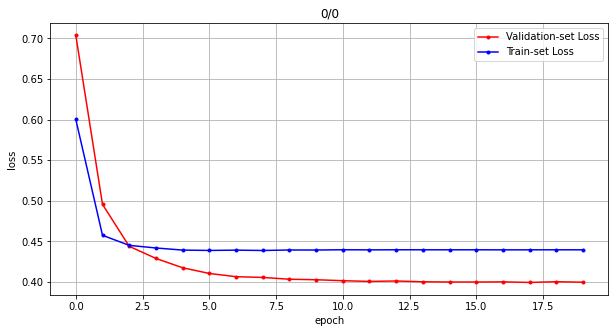

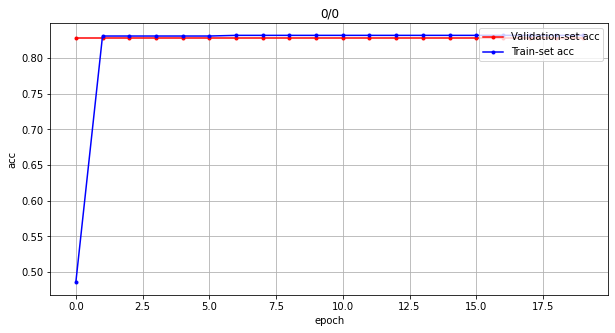

  0%|          | 0/67 [00:00<?, ?it/s]

Epoch: 0
Training Accuracy: 0.75, Loss: 0.59
Validation Accuracy: 0.83, Loss: 0.50


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

Epoch: 10
Training Accuracy: 0.83, Loss: 0.41
Validation Accuracy: 0.83, Loss: 0.45


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

Finished Training


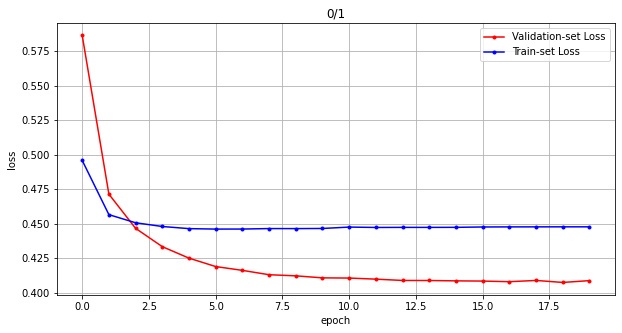

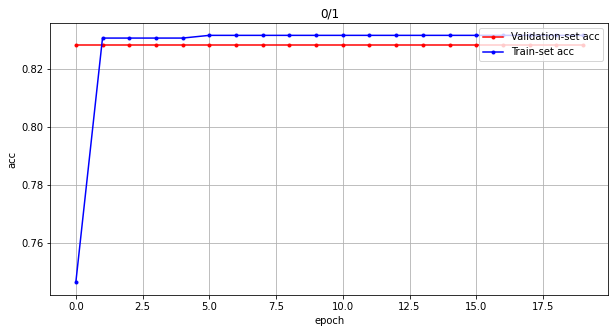

  0%|          | 0/67 [00:00<?, ?it/s]

Epoch: 0
Training Accuracy: 0.78, Loss: 0.55
Validation Accuracy: 0.83, Loss: 0.52


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

Epoch: 10
Training Accuracy: 0.83, Loss: 0.44
Validation Accuracy: 0.83, Loss: 0.41


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

Finished Training


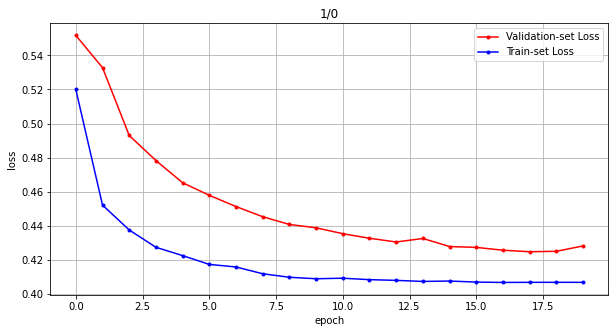

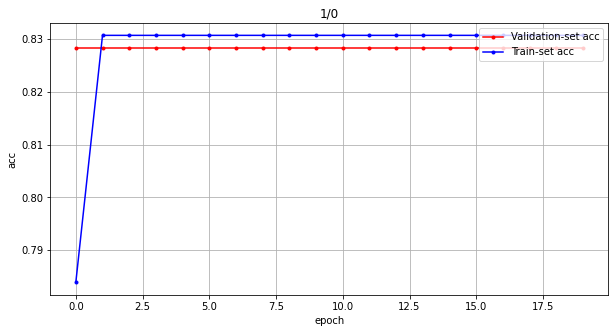

  0%|          | 0/67 [00:00<?, ?it/s]

Epoch: 0
Training Accuracy: 0.81, Loss: 0.53
Validation Accuracy: 0.83, Loss: 0.45


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

Epoch: 10
Training Accuracy: 0.83, Loss: 0.42
Validation Accuracy: 0.83, Loss: 0.40


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

Finished Training


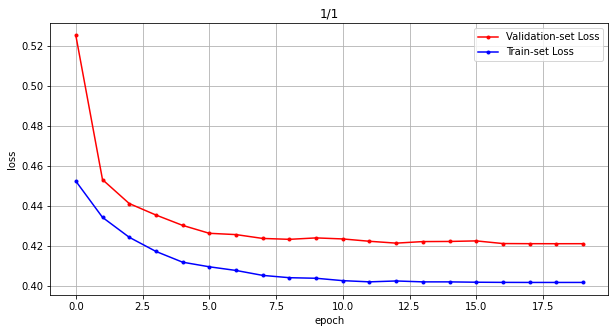

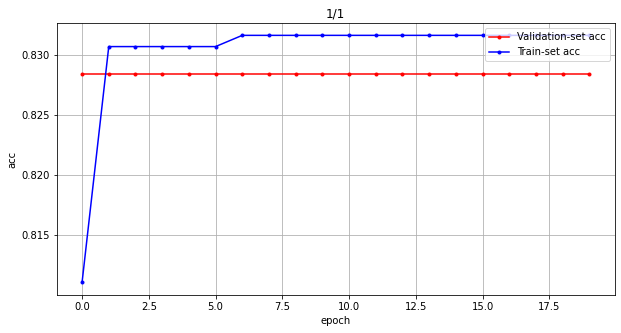

  0%|          | 0/67 [00:00<?, ?it/s]

Epoch: 0
Training Accuracy: 0.81, Loss: 0.53
Validation Accuracy: 0.83, Loss: 0.54


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

Epoch: 10
Training Accuracy: 0.83, Loss: 0.41
Validation Accuracy: 0.83, Loss: 0.56


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

Finished Training


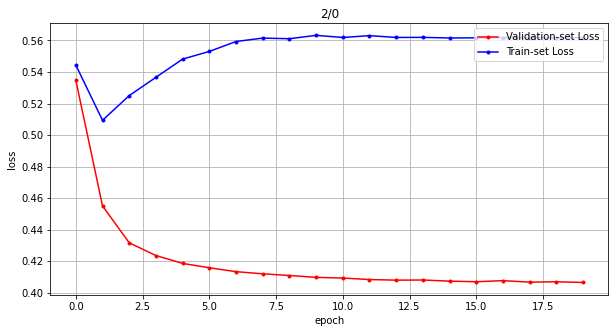

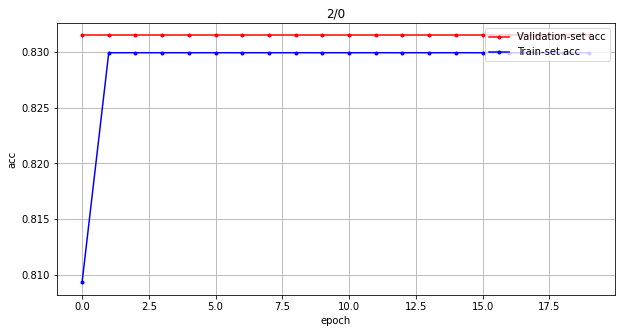

  0%|          | 0/67 [00:00<?, ?it/s]

Epoch: 0
Training Accuracy: 0.80, Loss: 0.54
Validation Accuracy: 0.83, Loss: 0.73


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

Epoch: 10
Training Accuracy: 0.83, Loss: 0.41
Validation Accuracy: 0.83, Loss: 0.68


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

Finished Training


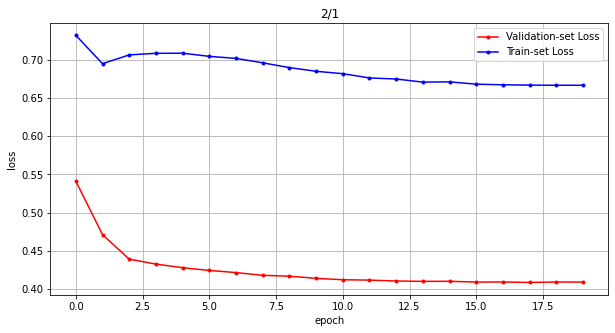

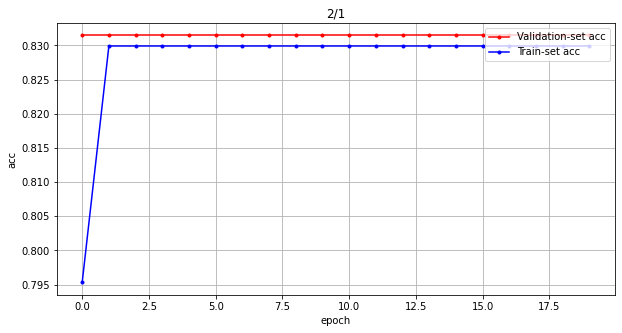

  0%|          | 0/67 [00:00<?, ?it/s]

Epoch: 0
Training Accuracy: 0.77, Loss: 0.57
Validation Accuracy: 0.83, Loss: 0.52


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

Epoch: 10
Training Accuracy: 0.83, Loss: 0.42
Validation Accuracy: 0.83, Loss: 0.41


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

Finished Training


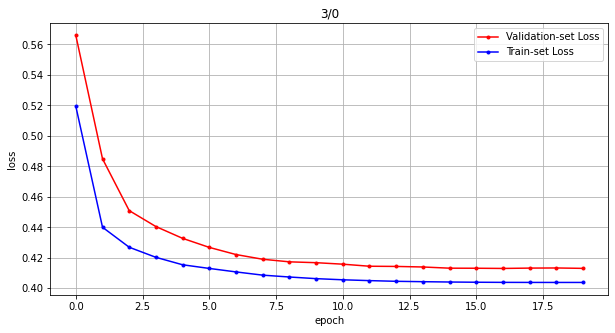

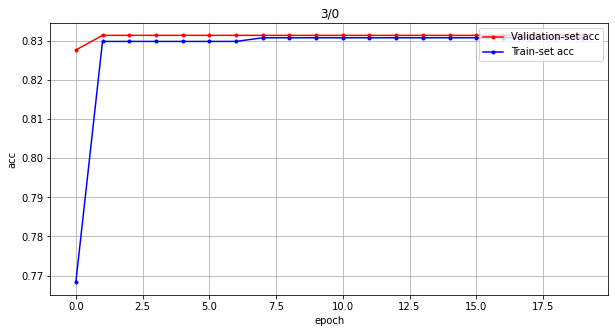

  0%|          | 0/67 [00:00<?, ?it/s]

Epoch: 0
Training Accuracy: 0.54, Loss: 0.67
Validation Accuracy: 0.82, Loss: 0.58


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

Epoch: 10
Training Accuracy: 0.83, Loss: 0.43
Validation Accuracy: 0.83, Loss: 0.42


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

Finished Training


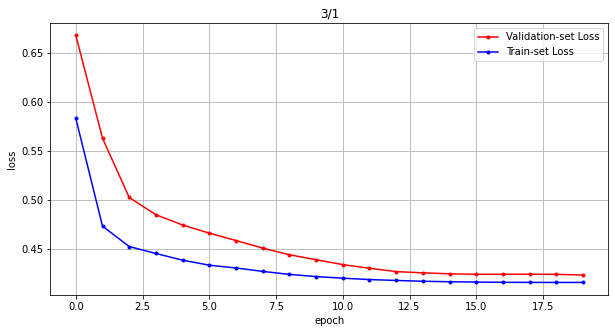

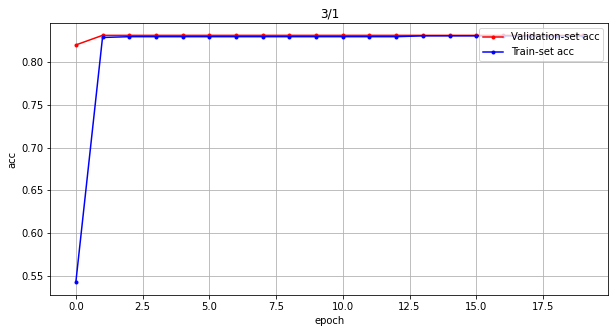

  0%|          | 0/67 [00:00<?, ?it/s]

Epoch: 0
Training Accuracy: 0.77, Loss: 0.57
Validation Accuracy: 0.82, Loss: 0.54


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

Epoch: 10
Training Accuracy: 0.83, Loss: 0.41
Validation Accuracy: 0.83, Loss: 0.41


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

Finished Training


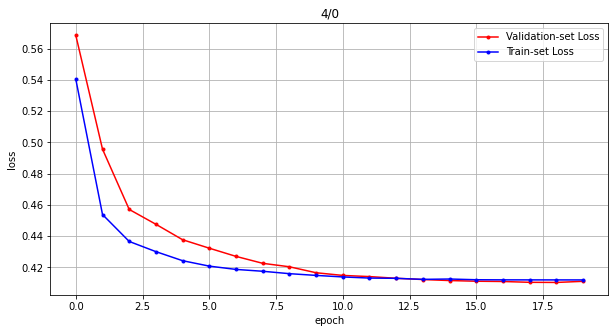

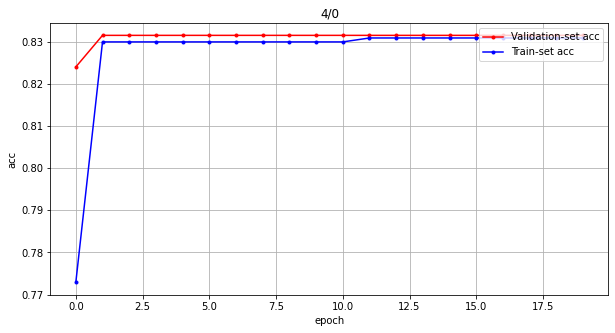

  0%|          | 0/67 [00:00<?, ?it/s]

Epoch: 0
Training Accuracy: 0.70, Loss: 0.68
Validation Accuracy: 0.83, Loss: 0.51


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

Epoch: 10
Training Accuracy: 0.83, Loss: 0.42
Validation Accuracy: 0.83, Loss: 0.42


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

Finished Training


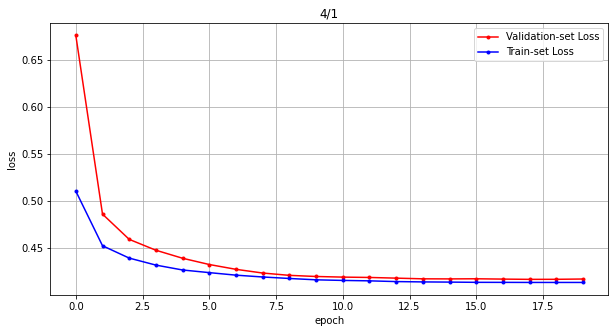

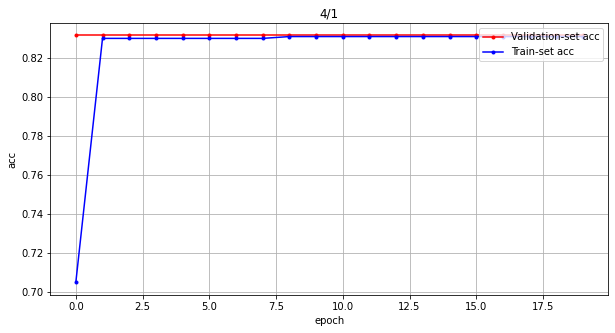

In [19]:
main(k_folded_data, s_c, 20)

In [32]:
# dataset proportion
total = len(train_y) + len(val_y)
print(f'train data proportion: {len(train_y)/total:.2f}, val: {len(val_y)/total:.2f}')
print(f'proportion label for 1 train:{list(train_y).count(1)/len(train_y):.2f}, val: {list(val_y).count(1)/len(val_y):.2f}')


train data proportion: 0.80, val: 0.20
proportion label for 1 train:0.83, val: 0.83


In [93]:
fin_model = BinaryClassifier(5).to(device)

run = train(20,train_loader, val_loader, fin_model)

entire_dataset = train_dataset+val_dataset
loader = DataLoader(entire_dataset, batch_size=1337, shuffle=False)

fin_model.eval()
with torch.no_grad():
    correct_prediction= 0
    for data in loader:
        inputs, targets = data[0].to(device), data[1].to(torch.int64).to(device)
        targets = torch.LongTensor(targets).squeeze()

        outputs = fin_model(inputs)
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction +=(prediction == targets).sum().item()
        
            
    acc = correct_prediction/len(entire_dataset)
    print(acc)
print(f'prediction for 1:{list(prediction).count(1)/len(prediction):.2f}, {list(prediction).count(1)}, 0:{list(prediction).count(0)/len(prediction):.2f}, {list(prediction).count(0)}')
# not all for 0 but very poor (few) decision for 1.


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch: 0
Training Accuracy: 0.82, Loss: 0.52
Validation Accuracy: 0.83, Loss: 0.51


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

Epoch: 10
Training Accuracy: 0.83, Loss: 0.41
Validation Accuracy: 0.83, Loss: 0.45


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

Finished Training
0.8302169035153328
prediction for 1:1.00, 1337, 0:0.00, 0


In [94]:
### To do.. data augmentation, data balancing.
print(prediction[:100])

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1])


In [69]:
data_ = pd.read_excel('./dataset/Pembrolizumab_preprocessing_training_input1.xlsx', usecols= columns_)
label_ = data_['Label']

In [90]:
# infer w/o training
model_test = BinaryClassifier(5).to(device)

entire_dataset = train_dataset+val_dataset
loader = DataLoader(entire_dataset, batch_size=1337, shuffle=False)

model_test.eval()
with torch.no_grad():
    correct_prediction= 0
    for data in loader:
        inputs, targets = data[0].to(device), data[1].to(torch.int64).to(device)
        targets = torch.LongTensor(targets).squeeze()

        outputs = model_test(inputs)
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction +=(prediction == targets).sum().item()
        
            
    acc = correct_prediction/len(entire_dataset)
    print(acc)
print(f'prediction for 1:{list(prediction).count(1)/len(prediction):.2f}, {list(prediction).count(1)}, 0:{list(prediction).count(0)/len(prediction):.2f}, {list(prediction).count(0)}')


0.7643979057591623
prediction for 1:0.93, 1239, 0:0.07, 98


In [ ]:
# precision, f1-score
# 문제 정의가 제대로 되어있는지. feature 선택할때 
# 딥러닝을 하고자 해서 features를 많이 가져왔는데 데이터수는 현저히 적어서 안됌.
# female, male 같은 feature
# 상관 관계 분석 우선
# 연구 성립이 안됌.